In [34]:
# Imports
import os,sys,inspect
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 
import matplotlib.dates as mdates
from time import time
import matplotlib.pyplot as plt
import plotly.offline as py 
%matplotlib inline
import random
import string
import re
import math

# Pre-processing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
import keras
import tensorflow as tf
from tensorflow import keras

# Classification model
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# Accuracy check
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from plotly.offline import iplot, plot, init_notebook_mode
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Graph embedding
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
from sklearn.metrics.pairwise import pairwise_distances
from gensim.models import Word2Vec
from networkx.algorithms.community.label_propagation import label_propagation_communities
# import community # python-louvain
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk, UnsupervisedSampler
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec as n2v_stellar
from stellargraph.layer import link_classification
from node2vec import Node2Vec as n2v

# Visualization 
import igraph as ig
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import iplot, plot, init_notebook_mode
from bokeh.io import output_notebook, show, save
from bokeh.models import *
from bokeh.plotting import figure, show, from_networkx
from bokeh.palettes import viridis, Viridis8
from bokeh.transform import linear_cmap
from networkx.algorithms import community
from sklearn.manifold import TSNE
from IPython.display import display, HTML
from community import community_louvain
output_notebook()

# Ignore matplotlib warnings
import warnings
warnings.filterwarnings("ignore")

# Shared instances
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

# Custom function
def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()
    
# Customized classification report including AUC
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            average='weighted'))
    
    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)
    support = class_report_df.loc['support']
    total = support.sum()
    class_report_df['avg / total'] = avg[:-1] + [total]
    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total
    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int),
                y_score[:, label_it])
            roc_auc[label] = auc(fpr[label], tpr[label])
        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(),
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(),
                        y_score.ravel())
            roc_auc["avg / total"] = auc(
                fpr["avg / total"],
                tpr["avg / total"])
        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))
            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])
            # Finally average it and compute AUC
            mean_tpr /= n_classes
            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr
            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])
        class_report_df['AUC'] = pd.Series(roc_auc)
    return class_report_df

def get_auc(y, y_pred_probabilities, class_labels, column =1, plot = True):
    fpr, tpr, _ = roc_curve(y == column, y_pred_probabilities[:,column],drop_intermediate = False)
    roc_auc = roc_auc_score(y_true=y, y_score=y_pred_probabilities[:,1])
    print ("AUC: ", roc_auc)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Loading BokehJS ...

In [2]:
# Load Dataframe 
sampled_trans_3w = pd.read_csv(r'sampled_trans_3w_M1.csv')
sampled_trans_3w.shape

(107400, 7)

In [3]:
sampled_trans_3w

,Unnamed: 0,input_address,output_address,weight,input_flag,output_flag,flag
0,0,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,17GVsLMCtXvZeRzFBTq8dss7c7zRfCw575,1.777559e+04,0,0,0
1,1,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,1GgzKmUjhCqLzG2b5Yi8uPmuUjQcwDSr8o,3.728313e+04,0,0,0
2,2,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,3KntMPFf6WSpkhfzvQjSK3bkB6R9DkEexk,1.896843e+02,0,0,0
3,3,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,1MfxMrrFwiVsizAD3ZRxDX4J971qupjnn7,6.216230e+04,0,0,0
4,4,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,1N8oMRSeBAxBLAtrcYXexmdRiWPs7r3pwu,1.178197e+04,0,0,0
...,...,...,...,...,...,...,...
107395,107395,3Gbt7Tyhr49nhoFsWk8TtGuDXTSru75chG,1FdW6qRHqj1e33BZ3vWsZYbC9MHFY7C38z,2.288890e+07,0,0,0
107396,107396,1GGvYkTFTZpMvXYaL6iiY94H3tV7iQgtJ5,1LXX2gb79MgB83uSMF2g7H2PfWvRvUg2h4,1.470000e+03,0,0,0
107397,107397,1NwtsEARuQVmMWd5woB37Wn3CnG8jSNMJd,1LVZDVYcCfi19fEUQh7M1GeuZh5g8LwJmP,7.878171e+05,0,0,0
107398,107398,16muHNCasNWuLDZDc8shMwquHihaqUcfED,13YG658V5PvLFjpwuSCpUotBvM6UKQgsHG,3.526915e+02,0,0,0


In [4]:
# Load Dataframe 
sampled_nodes = pd.read_csv(r'sampled_nodes_M1.csv')
sampled_nodes = sampled_nodes.drop(['Unnamed: 0'], axis = 1)
sampled_nodes.shape

(50000, 2)

In [5]:
sampled_nodes

,address,flag
0,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,0
1,1HjA5PafWKa4ngfDUBy45fsjafMajgqYp7,0
2,3Q386Wp1Y927QTXNRZaWETzbJ6RAn4vkam,0
3,17WK4vy6omBoW2kuaw7aqVVyuJn5Dn2vUy,0
4,1PMJEFQYeer5hcneH9i1stjV8Uj2RQup7M,0
...,...,...
49995,1JBg3mudKCeZJ3wRKZxdtVevSpCXeg3Hrn,0
49996,1NwtsEARuQVmMWd5woB37Wn3CnG8jSNMJd,0
49997,1NieKATXpZE19eKv8nYdMNxsBrSwp5dU1c,0
49998,1Q3yuiYmkXAcsGAg1q1GCyqXMX9k6n8hsK,0


In [6]:
# Load the graph
graph = nx.read_pajek('g_M1_50k.net')
print(f"The full network has {graph.number_of_nodes()} nodes.")
print(f"The full network has {graph.number_of_edges()} edges.")

The full network has 50000 nodes.
The full network has 107400 edges.


In [7]:
# Create the directed multigraph of the network using stellargraph library
graph = StellarGraph.from_networkx(graph)
graph.info()

'StellarDiGraph: Directed multigraph\n Nodes: 50000, Edges: 107400\n\n Node types:\n  default: [50000]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [107400]\n        Weights: range=[0.146799, 2.0534e+11], mean=2.45195e+07, std=7.74622e+08\n        Features: none'

### Node2Vec from stellargraph

In [8]:
# Generate random walks for mapping the network
walk_count = 5
walk_length = 4
karate_walk = BiasedRandomWalk(
    graph,
    n=walk_count,
    length=walk_length,
    p=0.5,  
    q=2.0, )

unsupervised_samples = UnsupervisedSampler(graph, nodes=list(graph.nodes()), walker=karate_walk)
batch_size = 32
epochs = 3
generator = Node2VecLinkGenerator(graph, batch_size)
emb_size = 100

In [9]:
# Train the model for embeddings size 100
node2vec = n2v_stellar(emb_size, generator=generator)
x_inp, x_out = node2vec.in_out_tensors()
predictions = prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],)

link_classification: using 'dot' method to combine node embeddings into edge embeddings


In [11]:
# Fit the model
history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,)

Epoch 1/3
46875/46875 [==============================] - 936s 20ms/step - loss: 0.5511 - binary_accuracy: 0.6590
Epoch 2/3
46875/46875 [==============================] - 824s 18ms/step - loss: 0.5090 - binary_accuracy: 0.7103
Epoch 3/3
46875/46875 [==============================] - 962s 21ms/step - loss: 0.5208 - binary_accuracy: 0.7228


In [12]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)
unique_ids = np.unique(list(sampled_trans_3w["input_address"]) + 
                     list(sampled_trans_3w["output_address"]))
unique_ids = pd.DataFrame({"Node_ids":unique_ids })
unique_ids = pd.merge(unique_ids,sampled_trans_3w, how = "left", left_on = "Node_ids", right_on = "input_address")
unique_ids = pd.merge(unique_ids,sampled_trans_3w, how = "left", left_on = "Node_ids", right_on = "output_address")
unique_ids.head(10)

,Node_ids,Unnamed: 0_x,input_address_x,output_address_x,weight_x,input_flag_x,output_flag_x,flag_x,Unnamed: 0_y,input_address_y,output_address_y,weight_y,input_flag_y,output_flag_y,flag_y
0,1111DAYXhoxZx2tsRnzimfozo783x1yC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7647.0,14tvuPm4kfCcxjJt2U627ycm4hwi4WMiyV,1111DAYXhoxZx2tsRnzimfozo783x1yC2,1.354624e+06,0.0,0.0,0.0
1,1111DAYXhoxZx2tsRnzimfozo783x1yC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43653.0,12xGquFHhQsp9oMbjQfGcfVpvTx3eeJ2d7,1111DAYXhoxZx2tsRnzimfozo783x1yC2,4.210749e+06,0.0,0.0,0.0
2,1111DAYXhoxZx2tsRnzimfozo783x1yC2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89759.0,1PyLWDkmZuyN6mn5uxdYSiTUz58Wnabc1d,1111DAYXhoxZx2tsRnzimfozo783x1yC2,1.714276e+06,0.0,0.0,0.0
3,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,760.0,1LSgEKji3ZoGdvzBgkcJMej74iBd38fySb,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,3.880953e+08,0.0,0.0,0.0
4,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,12561.0,1PMchNXJbhbgPfGfs3BEaZqkXuMx5u3bES,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,1.732520e+05,0.0,0.0,0.0
5,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,50356.0,12VpNLvUEBZvHL8WzjRcvoZKJ4KPdbJHko,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,4.904346e+06,1.0,0.0,1.0
6,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,55001.0,3JxyoBNPqgxWqufXMjAVqSAWepjhh5UEmQ,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,1.354144e+05,0.0,0.0,0.0
7,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,68768.0,1KP4okYYGQMvTqcoB5ygRr5gSUHohSuZkL,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,2.343406e+06,0.0,0.0,0.0
8,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,78867.0,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,13vHWR3iLsHeYwT42RnuKYNBoVPrKKZgRv,7.064819e+08,0.0,1.0,1.0,71264.0,17A16QmavnUfCW11DAApiJxp7ARnxN5pGX,111khWGs3Mj7UgKT7aS6hLsYK11ii4Gmw,2.126077e+08,0.0,0.0,0.0
9,1121AYuXWJ7gyNMQ2ZamBCJYKwMAKgscX6,87193.0,1121AYuXWJ7gyNMQ2ZamBCJYKwMAKgscX6,1LLs4xJKiZaRbthmsDLRPLJPYESnPYUAcC,6.710518e+06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
source_vals = sampled_trans_3w[["input_address","flag"]].drop_duplicates()
source_vals.columns = ["Node_ID","flag"]
target_vals = sampled_trans_3w[["output_address","flag"]].drop_duplicates()
target_vals.columns = ["Node_ID","flag"]
testing = source_vals.append(target_vals)
testing = testing.drop_duplicates(subset = "Node_ID",keep = "first")
node_gen = Node2VecNodeGenerator(graph, batch_size).flow(graph.nodes())
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

  66/1563 [>.............................] - ETA: 3s

2022-06-06 04:09:21.879350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 3s 2ms/step


In [14]:
print(pd.DataFrame(node_embeddings).shape)
pd.DataFrame(node_embeddings).head()

(50000, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.193537,-0.456769,0.177042,0.272516,0.936438,-0.355557,0.065851,-0.263816,-0.685916,-0.188249,...,-0.452159,-0.731193,-0.477322,-0.854288,0.104103,0.620328,0.533380,1.235561,-0.718353,0.572134
1,0.566429,0.985004,0.714954,0.330512,-0.752682,0.589297,1.060632,0.790166,-0.287099,0.630824,...,-0.204938,-0.195732,-0.627567,0.395128,-0.442090,0.477947,0.279306,-0.124081,-0.409071,-0.430719
2,0.894783,-0.638676,0.430807,1.335825,-0.568389,0.758762,1.133804,0.135987,0.573748,0.171627,...,-0.348430,0.600548,0.839735,0.004544,-0.839404,-1.089252,1.495883,0.485760,0.312852,-0.482206
3,0.949869,0.999868,-0.813187,0.154172,-0.632691,-1.486950,0.155396,0.294088,-0.339750,0.680532,...,-0.669299,0.241711,0.419269,0.436362,-0.243379,-0.039870,0.846789,-0.546872,1.049117,-0.319193
4,0.442978,0.403697,0.033418,-0.179008,-0.952854,0.503330,1.302359,1.175007,0.115083,-0.404246,...,-0.564347,-0.098700,0.313740,-1.204663,-0.099082,-0.776296,0.451168,0.663920,0.681936,-0.151570


In [15]:
# Save to csv
node_embeddings_df = pd.DataFrame(node_embeddings)
print(node_embeddings_df.shape)
node_embeddings_df.to_csv("embeddings_M1_50k.csv")

(50000, 100)


### Add  fraudulent flag to embeddings

In [16]:
# Create the network dataset for further predictions
network = pd.concat([sampled_nodes, node_embeddings_df], axis=1)
network

,address,flag,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,0,-0.193537,-0.456769,0.177042,0.272516,0.936438,-0.355557,0.065851,-0.263816,...,-0.452159,-0.731193,-0.477322,-0.854288,0.104103,0.620328,0.533380,1.235561,-0.718353,0.572134
1,1HjA5PafWKa4ngfDUBy45fsjafMajgqYp7,0,0.566429,0.985004,0.714954,0.330512,-0.752682,0.589297,1.060632,0.790166,...,-0.204938,-0.195732,-0.627567,0.395128,-0.442090,0.477947,0.279306,-0.124081,-0.409071,-0.430719
2,3Q386Wp1Y927QTXNRZaWETzbJ6RAn4vkam,0,0.894783,-0.638676,0.430807,1.335825,-0.568389,0.758762,1.133804,0.135987,...,-0.348430,0.600548,0.839735,0.004544,-0.839404,-1.089252,1.495883,0.485760,0.312852,-0.482206
3,17WK4vy6omBoW2kuaw7aqVVyuJn5Dn2vUy,0,0.949869,0.999868,-0.813187,0.154172,-0.632691,-1.486950,0.155396,0.294088,...,-0.669299,0.241711,0.419269,0.436362,-0.243379,-0.039870,0.846789,-0.546872,1.049117,-0.319193
4,1PMJEFQYeer5hcneH9i1stjV8Uj2RQup7M,0,0.442978,0.403697,0.033418,-0.179008,-0.952854,0.503330,1.302359,1.175007,...,-0.564347,-0.098700,0.313740,-1.204663,-0.099082,-0.776296,0.451168,0.663920,0.681936,-0.151570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1JBg3mudKCeZJ3wRKZxdtVevSpCXeg3Hrn,0,0.145134,0.169101,0.642155,0.865063,0.294787,-0.394623,0.651816,0.446024,...,-0.983794,0.141205,0.836289,0.318039,0.283750,-0.231165,-0.070910,1.008740,0.406538,0.339592
49996,1NwtsEARuQVmMWd5woB37Wn3CnG8jSNMJd,0,0.067379,0.744799,-0.494081,-0.517828,-0.506038,0.998109,-0.789111,0.913001,...,0.383086,0.684499,0.597028,0.005049,0.998869,0.491114,0.327933,0.137210,-0.664771,0.542367
49997,1NieKATXpZE19eKv8nYdMNxsBrSwp5dU1c,0,-0.503640,1.337569,-0.454532,-0.387960,0.505287,-0.208197,-0.103522,-0.005097,...,-0.611856,-0.309818,-0.725684,-1.032965,0.567296,-0.147500,0.311388,0.002932,0.943508,0.556513
49998,1Q3yuiYmkXAcsGAg1q1GCyqXMX9k6n8hsK,0,0.022001,-0.739370,0.196009,0.816410,0.007279,-0.436316,0.196915,-0.424612,...,0.072367,1.131685,-0.046852,0.031440,-0.214664,-0.542147,0.037382,0.301060,-0.478058,0.037294


In [17]:
# Add header for features by renaming columns
column_group = {str(ii): "feature_" + str(ii+1) for ii in range(100)}

column_all = dict(column_group)
column_all = {int(jj): item_kk for jj,item_kk in column_all.items()}

network = network.rename(columns=column_all)
network

,address,flag,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
0,32u8YzhY8rWTh85FLJaTbs55cKZxzJn9NM,0,-0.193537,-0.456769,0.177042,0.272516,0.936438,-0.355557,0.065851,-0.263816,...,-0.452159,-0.731193,-0.477322,-0.854288,0.104103,0.620328,0.533380,1.235561,-0.718353,0.572134
1,1HjA5PafWKa4ngfDUBy45fsjafMajgqYp7,0,0.566429,0.985004,0.714954,0.330512,-0.752682,0.589297,1.060632,0.790166,...,-0.204938,-0.195732,-0.627567,0.395128,-0.442090,0.477947,0.279306,-0.124081,-0.409071,-0.430719
2,3Q386Wp1Y927QTXNRZaWETzbJ6RAn4vkam,0,0.894783,-0.638676,0.430807,1.335825,-0.568389,0.758762,1.133804,0.135987,...,-0.348430,0.600548,0.839735,0.004544,-0.839404,-1.089252,1.495883,0.485760,0.312852,-0.482206
3,17WK4vy6omBoW2kuaw7aqVVyuJn5Dn2vUy,0,0.949869,0.999868,-0.813187,0.154172,-0.632691,-1.486950,0.155396,0.294088,...,-0.669299,0.241711,0.419269,0.436362,-0.243379,-0.039870,0.846789,-0.546872,1.049117,-0.319193
4,1PMJEFQYeer5hcneH9i1stjV8Uj2RQup7M,0,0.442978,0.403697,0.033418,-0.179008,-0.952854,0.503330,1.302359,1.175007,...,-0.564347,-0.098700,0.313740,-1.204663,-0.099082,-0.776296,0.451168,0.663920,0.681936,-0.151570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1JBg3mudKCeZJ3wRKZxdtVevSpCXeg3Hrn,0,0.145134,0.169101,0.642155,0.865063,0.294787,-0.394623,0.651816,0.446024,...,-0.983794,0.141205,0.836289,0.318039,0.283750,-0.231165,-0.070910,1.008740,0.406538,0.339592
49996,1NwtsEARuQVmMWd5woB37Wn3CnG8jSNMJd,0,0.067379,0.744799,-0.494081,-0.517828,-0.506038,0.998109,-0.789111,0.913001,...,0.383086,0.684499,0.597028,0.005049,0.998869,0.491114,0.327933,0.137210,-0.664771,0.542367
49997,1NieKATXpZE19eKv8nYdMNxsBrSwp5dU1c,0,-0.503640,1.337569,-0.454532,-0.387960,0.505287,-0.208197,-0.103522,-0.005097,...,-0.611856,-0.309818,-0.725684,-1.032965,0.567296,-0.147500,0.311388,0.002932,0.943508,0.556513
49998,1Q3yuiYmkXAcsGAg1q1GCyqXMX9k6n8hsK,0,0.022001,-0.739370,0.196009,0.816410,0.007279,-0.436316,0.196915,-0.424612,...,0.072367,1.131685,-0.046852,0.031440,-0.214664,-0.542147,0.037382,0.301060,-0.478058,0.037294


In [18]:
# Save to csv
network.to_csv("network_m1.csv")

### Visualise node embeddings

In [19]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)
node_targets = network['flag']

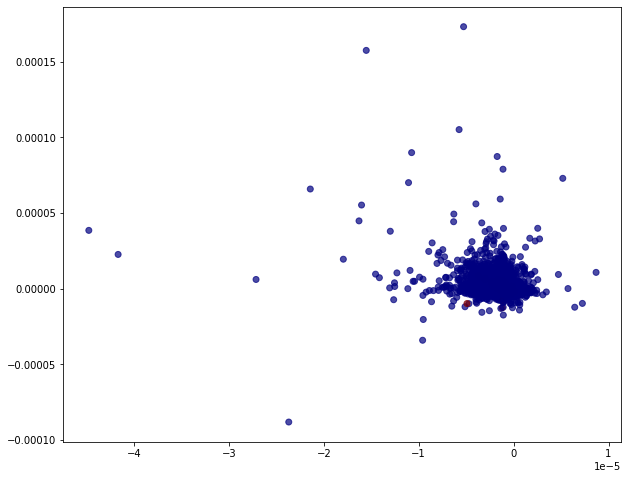

In [20]:
# Draw the points
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_targets))}
node_colours = [label_map[target] for target in node_targets]

plt.figure(figsize=(10, 8))
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,)

# Step 5. Build classification model

In [21]:
network['flag'].value_counts()

0    49681
1      319
Name: flag, dtype: int64

In [22]:
# Drop address from csv
network = network.drop(['address'], axis=1)

# Split target variable from its regressors
X = network.drop(['flag'], axis = 1)
y = network['flag']

# Reconvert back to dataframe from numpy array
X = pd.DataFrame(X)
X

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100
0,-0.193537,-0.456769,0.177042,0.272516,0.936438,-0.355557,0.065851,-0.263816,-0.685916,-0.188249,...,-0.452159,-0.731193,-0.477322,-0.854288,0.104103,0.620328,0.533380,1.235561,-0.718353,0.572134
1,0.566429,0.985004,0.714954,0.330512,-0.752682,0.589297,1.060632,0.790166,-0.287099,0.630824,...,-0.204938,-0.195732,-0.627567,0.395128,-0.442090,0.477947,0.279306,-0.124081,-0.409071,-0.430719
2,0.894783,-0.638676,0.430807,1.335825,-0.568389,0.758762,1.133804,0.135987,0.573748,0.171627,...,-0.348430,0.600548,0.839735,0.004544,-0.839404,-1.089252,1.495883,0.485760,0.312852,-0.482206
3,0.949869,0.999868,-0.813187,0.154172,-0.632691,-1.486950,0.155396,0.294088,-0.339750,0.680532,...,-0.669299,0.241711,0.419269,0.436362,-0.243379,-0.039870,0.846789,-0.546872,1.049117,-0.319193
4,0.442978,0.403697,0.033418,-0.179008,-0.952854,0.503330,1.302359,1.175007,0.115083,-0.404246,...,-0.564347,-0.098700,0.313740,-1.204663,-0.099082,-0.776296,0.451168,0.663920,0.681936,-0.151570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.145134,0.169101,0.642155,0.865063,0.294787,-0.394623,0.651816,0.446024,0.724990,-0.054090,...,-0.983794,0.141205,0.836289,0.318039,0.283750,-0.231165,-0.070910,1.008740,0.406538,0.339592
49996,0.067379,0.744799,-0.494081,-0.517828,-0.506038,0.998109,-0.789111,0.913001,0.723896,0.379996,...,0.383086,0.684499,0.597028,0.005049,0.998869,0.491114,0.327933,0.137210,-0.664771,0.542367
49997,-0.503640,1.337569,-0.454532,-0.387960,0.505287,-0.208197,-0.103522,-0.005097,-0.438133,-0.131253,...,-0.611856,-0.309818,-0.725684,-1.032965,0.567296,-0.147500,0.311388,0.002932,0.943508,0.556513
49998,0.022001,-0.739370,0.196009,0.816410,0.007279,-0.436316,0.196915,-0.424612,0.156949,-0.288867,...,0.072367,1.131685,-0.046852,0.031440,-0.214664,-0.542147,0.037382,0.301060,-0.478058,0.037294


In [23]:
# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Array shapes:\n X_train = {}\n y_train = {}\n X_test = {}\n y_test = {}".format(
        X_train.shape, y_train.shape, X_test.shape, y_test.shape))

class_labels = ['Licit', 'Illicit']

Array shapes:
 X_train = (40000, 100)
 y_train = (40000,)
 X_test = (10000, 100)
 y_test = (10000,)


In [24]:
# Generate new samples by randomly sampling with replacement the underrepresented class
sampling_strategy = 0.3
sampling = RandomOverSampler(sampling_strategy = sampling_strategy)
X_train, y_train = sampling.fit_resample(X_train, y_train) 

y_train.value_counts()

0    39737
1    11921
Name: flag, dtype: int64

In [33]:
y_test.value_counts()

0    9944
1      56
Name: flag, dtype: int64

#### Basic Logistic Regression

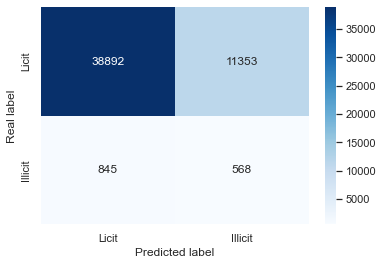

             precision    recall  f1-score  support     pred       AUC
0             0.774047  0.978735  0.864440  39737.0  50245.0  0.698226
1             0.401982  0.047647  0.085196  11921.0   1413.0  0.698226
avg / total   0.688186  0.763870  0.684615  51658.0  51658.0  0.698226


In [35]:
# Logistic Regression classifier
classifier = LogisticRegression()

# Producing predictions
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_test_pred = classifier.predict(X_test)

# Computing the predicted probabilities 
y_train_probab = classifier.predict_proba(X_train)
y_test_probab = classifier.predict_proba(X_test)

# Computing the confusion matrix to assess in-sample misclassification errors (false positives and false negatives)
cm =  confusion_matrix(y_train_pred, y_train)

# Plotting confusion matrix 
plot_confusion_matrix(cm, class_labels)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_train, 
    y_pred = y_train_pred, 
    y_score = y_train_probab)
print(report_with_auc)

# We want to penalise false negatives, so we should be looking at recall (and maybe f1) as scorers
# False negatives would show any illicit nodes that were marked as licit. That's what anyone who reports to a regulator would care about. Recall would work best here
# F1 considers both false negatives and positives, so we can argue that this shows how a company would balance business and regulation

AUC:  0.6982260704540035


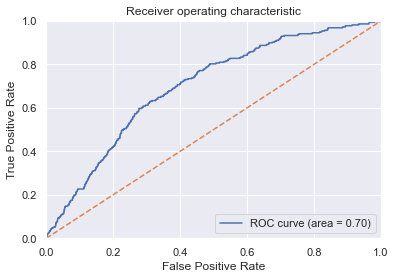

In [37]:
# Assess expected accuracy using AUC/ROC 
get_auc(y_train, y_train_probab, class_labels, column=1, plot=True)

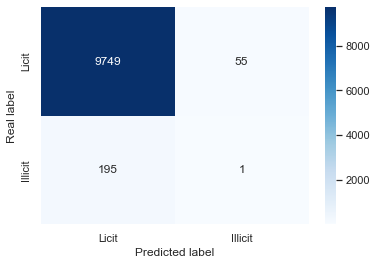

AUC:  0.5748495144236294


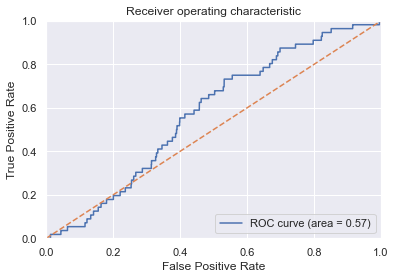

             precision    recall  f1-score  support     pred      AUC
0             0.994390  0.980390  0.987340   9944.0   9804.0  0.57485
1             0.005102  0.017857  0.007937     56.0    196.0  0.57485
avg / total   0.988850  0.975000  0.981856  10000.0  10000.0  0.57485


In [38]:
# Out-sample performance
cm =  confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_test, y_test_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_test, 
    y_pred = y_test_pred, 
    y_score = y_test_probab)
print(report_with_auc)

#### Random Forest with tunned parameters
A random forest ensambles over decision trees. This takes the average of many decision trees using bagging, i.e. “bootstrap aggregation,” meaning that samples are chosen with replacement, and combined by taking their average. This reduces sampling bias.

In [40]:
# Instanciate Model
forest = RandomForestClassifier() 

# Hyperparameters grid
forest_params = {'n_estimators': range(50, 100), # standard range of trees to estimate
                 'max_features': range(4, 30), # Range around sqrt of #features and the total #features
                 'max_depth': range(3, 10), # deafult=None, capping max depth can reduce over-fitting
                 'min_samples_split': range(2, 10), # default=2, larger samples can guard against over-fitting
                 'min_samples_leaf': range(2, 10), # default=1, larger samples can guard against over-fitting
                 'bootstrap': [True]} # bootstrap=True reduces over-fitting by also sampling across observations
                 
# Instantiate RandomisedSearch
rforest = RandomizedSearchCV(forest, param_distributions=forest_params, scoring='roc_auc',  
                             n_jobs=-1, random_state=42, cv=10)

# Fit RandomisedSearch to training data
rforest.fit(X_train, y_train)

y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Computing the predicted probabilities 
y_train_probab = rforest.predict_proba(X_train)
y_test_probab = rforest.predict_proba(X_test)

# List best hyperparameters
print("Best estimators for Random Forest:\n", rforest.best_estimator_)

Best estimators for Random Forest:
 RandomForestClassifier(max_depth=9, max_features=10, min_samples_leaf=9,
                       min_samples_split=6, n_estimators=80)


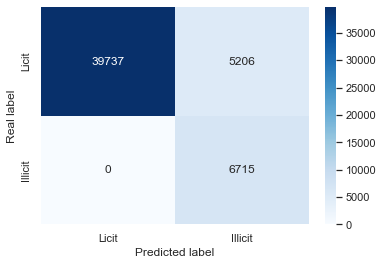

AUC:  0.9999969664650435


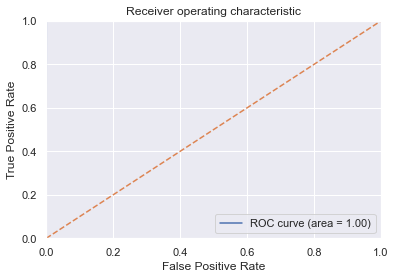

             precision    recall  f1-score  support     pred       AUC
0             0.884164  1.000000  0.938521  39737.0  44943.0  0.999997
1             1.000000  0.563292  0.720648  11921.0   6715.0  0.999997
avg / total   0.910896  0.899222  0.888243  51658.0  51658.0  0.999997


In [41]:
# In sample accuracy
cm =  confusion_matrix(y_train_pred, y_train)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_train, y_train_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_train, 
    y_pred = y_train_pred, 
    y_score = y_train_probab)
print(report_with_auc)

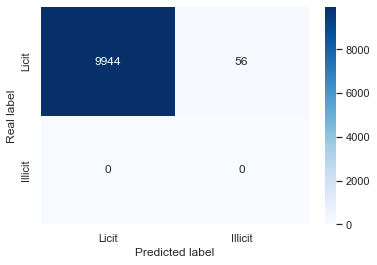

AUC:  0.6046485317779565


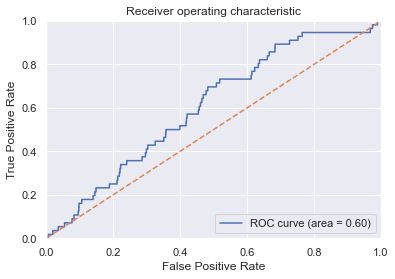

             precision  recall  f1-score  support     pred       AUC
0             0.994400  1.0000  0.997192   9944.0  10000.0  0.604649
avg / total   0.988831  0.9944  0.991608   9944.0   9944.0  0.604649


In [42]:
# Out-sample performance
cm =  confusion_matrix(y_test_pred, y_test)
plot_confusion_matrix(cm, class_labels)

# Assess expected accuracy using AUC/ROC 
get_auc(y_test, y_test_probab, class_labels, column=1, plot=True)

# Customized classification report including AUC
report_with_auc = class_report(
    y_true = y_test, 
    y_pred = y_test_pred, 
    y_score = y_test_probab)
print(report_with_auc)

In [43]:
# # Estimate out-sample acurracy
# accuracies = cross_val_score(estimator=rforest, X=X_test, y=y_test, cv=10, n_jobs=-1)
# print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
# print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))